# Towards Evaluating Creativity in Language

This notebook is a prototype for evaluating creativity in language. It is based on the paper [Towards Evaluating Creativity in Language](https://arxiv.org/abs/1904.09751) by [Rudinger et al.](https://arxiv.org/abs/1904.09751) (2019).
^ bruh copilot at it again

In [76]:
from nltk.corpus import gutenberg
import numpy.typing as ntp
from classes.benchmark import *
# from classes.models import *
# Initialize models
import torch
from transformers import AutoTokenizer, BertForMaskedLM
import gensim
from nltk.data import find
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(
    str(find('models/word2vec_sample/pruned.word2vec.txt')), binary=False)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
bench = CreativityBenchmark(gutenberg.raw("austen-emma.txt"), "Emma")
# bench.report()


### Potential creativity measures
#### Usage of less common vocabulary uncommon words
**Example:**
- "The quick brown fox jumps over the lazy dog."
- "The swift hazel-furred fox leaps over the idle dog."

**Idea:**

Adapt resources such as WordNet for finding semantically similar words and compare them to their most used synonym. Notion: The more uncommon the word, the more creative the sentence.
Potential problems: words could be too far off from their actual meaning in the context. For example, here "leaps" is a synonym for "jumps", but using the word "vaults" or "springs" might not fit the context.


#### Comparing alternatives for bi(+)grams 
(Generally, we want to narrow down on adjectives and noun phrases, but this could be expanded to verb phrases for example.)  
**Two variants:**
1. Compare how much the original word deviates in comparison to contextual synonyms/alternatives. That is, compare $ P(w_{original}|context) $ with $ \{P(w| context) | w \text{ in the set of alternative continuations}\} $. **This is somewhat akin to the perplexity measure, I believe?**
   - *Example:* (The following has been generated by Copilot) Given the sentence "The quick brown fox jumps over the lazy dog.", the context word is "fox" and the alternative contexts are "dog" and "cat". The probability of "jumps" given "fox" is compared to the probabilities of "jumps" given "dog" and "cat". 
   - **Alternatively**, to simplify the formulas, we can compare the deviation of probability $ P(w_{original}|context) $ with respect to the likeliest/largest/maximum element in the set of probability distribution described above, i.e. $\max (\{ P(w|context) | w \in S_{Alternatives}\})$ 


2. Compare the deviation of probability $ P(word|modifier) $ with respect to the set $ \{P(word| alt) | alt \text{ in the set of alternative modifiers}\}$
   - *Example:* Given the sentence "The quick *brown* **fox** jumps over the lazy dog.", the $word$ is **"fox"** and the $modifier$ is *"brown"*. Then, the alternative modifiers can be "black", "reddish", or even "blue".
   - This can be summarised by doing evaluation on the noun phrase level. I'd personally prefer focusing on the prepositional modifier words.

Possible algorithm for measuring number of tokens per sentence:
1. Split the text into sentences using the sentence tokenizer.
2. For each sentence, split it into tokens using the word tokenizer.

Additionally, plot the distribution of the number of tokens per sentence.
Additionally, plot the distribution of different PoS tags per sentence.
Do this for a few genres and compare them. PLOT PLOTS PLOTS


### Distance measure based on semantic tree traversal
**Idea:**

- Given a sentence, tag words into parts of speech using the Universal tagset (we prefer not to use the PennTreebank tagset as it is too English-specific and would not mesh well with WordNet).
- Filter only to nouns, adjectives, verbs, and adverbs. 
- Given each tagged word, we find its synset (i.e. the set of synonyms) in WordNet.
- Compute some distance metric between the synsets of the two words. For example, we can use the [Wu-Palmer similarity](https://www.nltk.org/howto/wordnet.html) measure.
- How do we calculate that for all the words in a given text/sentence? 

#### Potential Issues
Potential issues with this approach may include:
- The use of WordNet. It is a good resource, but it is not perfect. For example, it does not contain all the words in the English language.
- Setting. For example, some words may not be subsititutable in certain context. Say, the collocation "big sister" cannot be replaced with "large sister" or "huge sister". It completely alters the meaning of the phrase. For example, the word H2O is used in scientific contexts and would be inappropriate in a hiking guide—water would be more appropriate— and this genre difference is part of the meaning of the word. In practice, the word syn- onym is therefore used to describe a relationship of approximate or rough synonymy. \cite{jurafsky2014speechorwhatever}
- 
- 

#### Additional Datasets
For example the SimLex-999 dataset (Hill et al., 2015) gives values on a scale from 0 to 10, like the examples below, which range from near-synonyms (vanish, disappear) to pairs that scarcely seem to have anything in common (hole, agreement):
| word1 | word2| score |
|--------|-----------|-----|
| vanish | disappear | 9.8 |
| hole   | agreement | 1.2 |


Early work on affective meaning (Osgood et al., 1957) found that words varied along three important dimensions of affective meaning:
valence: the pleasantness of the stimulus
arousal: the intensity of emotion provoked by the stimulus dominance: the degree of control exerted by the stimulus

Osgood et al. (1957) noticed that in using these 3 numbers to represent the meaning of a word, the model was representing each word as a point in a three- dimensional space, a vector whose three dimensions corresponded to the word’s rating on the three scales. This revolutionary idea that word meaning could be rep- resented as a point in space (e.g., that part of the meaning of heartbreak can be represented as the point [2.45,5.65,3.58]) was the first expression of the vector se- mantics models that we introduce next. **You can paraphrase this**

In [3]:
# This implementation is shit, aye?
from nltk import wsd
from nltk.corpus import wordnet as wn
import pywsd

sentence = "The quick brown fox jumps over the lazy dog"
words = nltk.word_tokenize(sentence)
tagged: list[tuple[str, str]] = nltk.pos_tag(words, tagset='universal')
universal_to_wn = {'NOUN': wn.NOUN,
                   'VERB': wn.VERB, 'ADJ': wn.ADJ}
for word, tag in tagged:
    if tag not in universal_to_wn.keys():
        continue
    actual_word = pywsd.simple_lesk(sentence, word, universal_to_wn[tag])
    for method in [pywsd.simple_lesk, pywsd.cosine_lesk]:
        actual_word = method(sentence, word, universal_to_wn[tag])
        print(
            f"{word} - {tag} - {actual_word} - {word2vec_model.similarity(word, 'canine')} - {actual_word.definition() if actual_word else ''}")
    # print(
    #     f"{word} - {tag} - {actual_word, actual_word.definition() if actual_word else ''} - {wn.synsets(word, pos=universal_to_wn[tag])}")


quick - ADJ - Synset('agile.s.01') - 0.07056773453950882 - moving quickly and lightly
quick - ADJ - Synset('agile.s.01') - 0.07056773453950882 - moving quickly and lightly
brown - NOUN - Synset('brown_university.n.01') - 0.12424251437187195 - a university in Rhode Island
brown - NOUN - Synset('brown.n.01') - 0.12424251437187195 - an orange of low brightness and saturation
fox - NOUN - Synset('fox.n.07') - 0.31961506605148315 - the Algonquian language of the Fox
fox - NOUN - Synset('fox.n.03') - 0.31961506605148315 - the grey or reddish-brown fur of a fox
jumps - VERB - Synset('startle.v.02') - 0.0884588360786438 - move or jump suddenly, as if in surprise or alarm
jumps - VERB - Synset('jump.v.06') - 0.0884588360786438 - enter eagerly into
lazy - ADJ - Synset('lazy.s.01') - 0.05496400594711304 - moving slowly and gently
lazy - ADJ - Synset('lazy.s.01') - 0.05496400594711304 - moving slowly and gently
dog - NOUN - Synset('pawl.n.01') - 0.6918289065361023 - a hinged catch that fits into a

Plot average concreteness of words in a sentence

^^ 


## Alternative implementation for semantic distance measure which abuses masked language models for context-aware words

Initialize models

In [120]:
from typing import overload

# @overload
# def predict_tokens(sent: str, masked_word: str, model, return_tokens: bool = False, k: int = 20) -> list[float]: ...

# @overload
# def predict_tokens(sent: str, masked_word: str, model, return_tokens: bool = True, k: int = 20) -> tuple[list[str], list[float]]: ...


def predict_tokens(sent: str, masked_word: str, model, return_tokens: bool = False, k: int = 20):
    """Predict the top k tokens that could replace the masked word in the sentence. 

    Returns a list of tuples of the form (token, likelihood, similarity) where similarity is the cosine similarity of the given words in a word2vec model.

    Parameters
    ----------
    sent: str
        The sentence to predict tokens for.
    masked_word: str
        The word to predict tokens for. Note that this word must be in the sentence.
    model
        Must be a masked language model that takes in a sentence and returns a tensor of logits for each token in the sentence. Default assumes a pretrained BERT model from the HuggingFace `transformers` library.
    word2vec_model
        Must be a word2vec model that takes in a word and returns a vector representation of the word.
        Default is `gensim.models.keyedvectors.KeyedVectors` loaded from the `word2vec_sample` model from the `nltk_data` package.
    k: int
        The number of tokens to return.    

    Returns
    -------
    List of tuples the form (token, likelihood, similarity)

    token: str
        The predicted token.
    likelihood: float
        The likelihood of the token being the masked word.
    similarity: float
        The cosine similarity of the token and the masked word.
    """
    if masked_word not in sent:
        raise ValueError(f"{masked_word} not in {sent}")
    masked_sent = sent.replace(masked_word, "[MASK]")

    inputs = tokenizer(masked_sent, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    # retrieve index of [MASK]
    mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[
        0].nonzero(as_tuple=True)[0]

    vals, predicted_token_ids = torch.topk(
        logits[0, mask_token_index], k, dim=-1)

    ret = []
    tokens = []
    for i, predicted_token_id in enumerate(predicted_token_ids[0]):
        # if the actual tokens are needed, return those as well
        if return_tokens == True:
            word = tokenizer.decode(predicted_token_id)

            # If word is a subword, combine it with the previous word
            if word.startswith("##"):
                word = masked_word+word[2:]

            tokens.append(word)
        ret.append(vals[0, i].item())

    if return_tokens == True:
        return ret, tokens
    else:
        return ret


### Issues with Word2Vec
Does not quite capture part of speech senses.

**Remarks:**
1. Cosine similarity returns values in the range of $[0,1]$. The closer the value is to 1, the more similar the two vectors are. Although intuitively, a cosine function can range between $[-1, -1]$, the learned embeddings being used in `Word2Vec` themselves can inherently only have values in the range of $[0,1]$, so we cannot make assumptions for negative values, such as `Word_A` and `Word_B` are antonyms.

#### Benchmarking insights for speed concerns
Torch objects and NumPy arrays have effectively the same speed. However, NumPy arrays are more memory efficient.

In [78]:
def cross_softmax(x: np.ndarray, y: np.ndarray, temp1=0.5, temp2=0.5):
    # return (torch.softmax(torch.from_numpy(results[1][:,0]), dim=0) @ torch.softmax(torch.from_numpy(results[1][:,1]), dim=0)).item()
    exps = np.exp(x*temp1)
    exps /= exps.sum()
    exps2 = np.exp(y*temp2)
    exps2 /= exps2.sum()
    return exps @ exps2


def slope_coefficient(X: ntp.NDArray, Y: ntp.NDArray) -> float:
    """Returns the coefficient of the slope"""
    # Using the integrated function
    # return np.tanh(np.polyfit(X,Y,1)[0])
    # Manually implementing slope equation
    return ((X*Y).mean(axis=0) - X.mean()*Y.mean(axis=0)) / ((X**2).mean() - (X.mean())**2)


### Slope of the curve of likelihood of a word given a context
<!-- We explore how certainty of a word given a context changes as we move away from the context. (this is not a bad suggestion by copilot, but it strays from my original purpose for this project) -->
We explore how certainty for a prediction given some context changes in the likelihood space of the BERT MLM. In practice, this enables us to see how certain the model is about the predictions it is making, and it can potentially allow us to compare values across different contexts or same contexts but with different masked tokens.

The slope of a given curve has the following equation(where $x$ is the input and $y$ is the output):
$$
\sum_{i = 1} ^ n \frac{(x_i - \bar{x})(y_i - \bar{y})}{(x_i - \bar{x}) ^ 2}

$$


The first 100 sentences of Brown corpus (~1000 tokens) need 1.5 minutes to be processed. Not based at all.

In [5]:
bench = CreativityBenchmark(gutenberg.raw('bible-kjv.txt'))


In [137]:
def sent_predictions(sent: str | list[str], model: Any, return_tokens: bool = False, k: int = 20):
    """Returns predictions for content words in a given sentence. If return_tokens is true, returns a key-value pair dictionary where the key is the used word, and the value is a list of suggested tokens, corresponding to the likekihoods in the first list.

    Parameters
    ----------
    sent : str | list[str]
        The sentence to be used for evaluation. It can be either a list of words or a normal string.
    model : BertForMaskedLM
        _description_

    Returns
    -------
    list[NDArray]
        A list of Nx2 matrices where the first column is the likelihood of a given fill and the second column is the word2vec similarity with the masked word.

    Raises
    ------
    TypeError
        When the sentence is in the wrong type
    """
    if isinstance(sent, str):
        tokens = nltk.word_tokenize(sent.lower())
    elif isinstance(sent, list):
        tokens = [token.lower() for token in sent]
        sent = " ".join(tokens)
    else:
        raise TypeError()
    words = nltk.pos_tag(tokens, tagset='universal')

    results = []
    return_words = {}

    # loop over the words of the sentence
    for word, tag in words:
        # Early stopping
        if word in bench.stopwords or tag not in bench.tags_of_interest:
            continue

        if return_tokens == True:
            predicted_tokens, predicted_words = predict_tokens(
                sent, word, model, return_tokens=return_tokens, k=k)

            results.append(predicted_tokens)
            return_words[(word, tag)] = predicted_words
        else:
            predicted_tokens = predict_tokens(
                sent, word, model, return_tokens=return_tokens, k=k)
            results.append(predicted_tokens)

    if return_tokens == True:

        return [np.array(result) for result in results], return_words
    else:
        return [np.array(result) for result in results]


def calculate_sent_slopes(bench, model, n) -> list[list[float]]:
    # Returns slopes for the __words__ of the first `n` sentences of the `sents` list of sentences.
    res = []
    for sent in bench.tokenized_sents[:n]:
        results = sent_predictions(sent, model)

        res.append(
            [slope_coefficient(
                np.arange(len(result)),
                result)
             for result in results
             if len(result) > 0]
        )

    return res

# n = 10
# res = calculate_sent_slopes(bench, model, n)


In [171]:
def mean(items: Sequence) -> float:
    return sum(items)/len(items)


In [169]:
def calculate_sim_scores(bench, sim_function: Callable, max_sents=-1):
    similarity_scores = []
    for sent in bench.tokenized_sents[:max_sents]:

        probs, predictions = sent_predictions(
            sent, model, return_tokens=True, k=10)
        average_position_of_correct_prediction = 0
        # number of predictions which do not include the true value in the topmost k results
        missed_predictions = 0
        # note that word here is a tuple of the word and its POS tag
        i = 0
        for (word, predlist) in predictions.items():
            try:
                # print(word[0], predlist)
                average_position_of_correct_prediction += predlist.index(
                    word[0])
                i += 1
            except ValueError:
                missed_predictions += 1

        # Avoid division by zero error
        if i == 0:
            average_position_of_correct_prediction = None
        else:
            average_position_of_correct_prediction /= i
        similarity_scores.append(
            (average_position_of_correct_prediction, missed_predictions))
        break
        #     for item in predlist:
        # similarity_scores.append(
        #     [[sim_function(word[0], pred) for pred in predlist] for word,predlist in predictions.items()]
        # )

    return similarity_scores


def sim_func(word: str, pred: str) -> float | None:
    """Arbitrary function to use when calculating vector similarity between the embeddings of two words. Serves as an example.

    Parameters
    ----------
    word : str
        Normally, the original (true) value.
    pred : str
        Normally, the predicted value.

    Returns
    -------
    Optional[float]
        Can return a float or None.
    """
    try:
        return word2vec_model.similarity(word, pred)
    except:
        pass


calculate_sim_scores(bench, sim_func, 10)


[(2.25, 10)]

In [165]:
so = ["cow", "car", "pineapple"]
so.index("car")


1

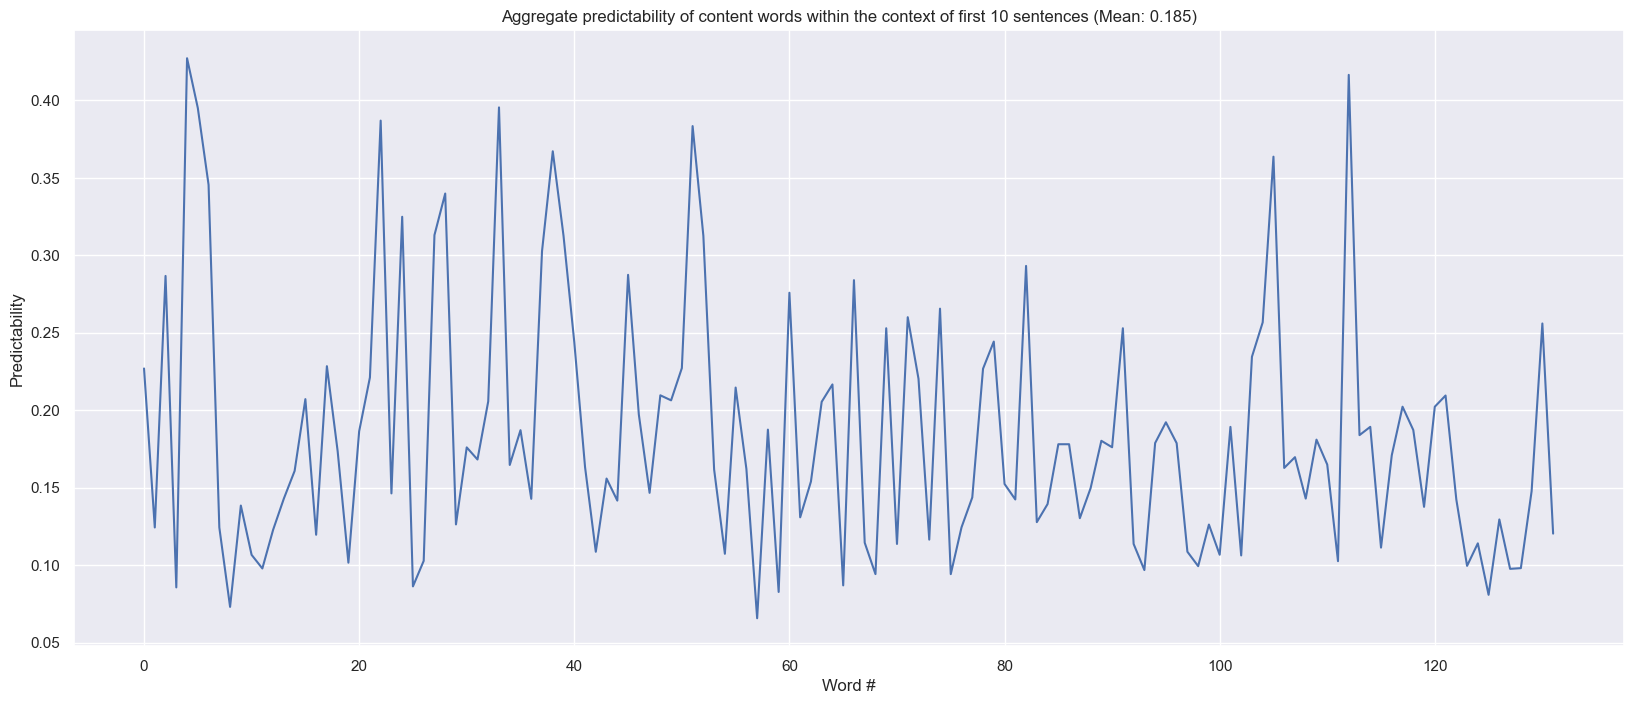

In [93]:
# flatten the list
plotting_list = np.array([item for sublist in res for item in sublist])
# invert likelihood
plotting_list = -plotting_list
plt.figure(figsize=(20, 8))
plt.plot(plotting_list)
plt.title(
    f"Aggregate predictability of content words within the context of first {n} sentences (Mean: {plotting_list.mean():.3f})")
plt.xlabel('Word #')
plt.ylabel('Predictability')


## Similar idea, but sentence-level instead of word-level
Use `BertForNextSentencePrediction` to determine how "unpredictable" the following sentence is given the previous sentence (as prompt). We mask the second sentence and take something like a cosine similarity / set difference between the two vectors.

In [1]:
from transformers import BertForNextSentencePrediction
model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased")

prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
next_sentence = "The sky is blue due to the shorter wavelength of blue light."

encoding = tokenizer(prompt, next_sentence, return_tensors="pt")
outputs = model(**encoding, labels=torch.LongTensor([1]))

logits = outputs.logits
print(logits[0, 0], logits[0, 1])  # next sentence was random


: 

: 

## Notes
- What current approaches to creativity evaluation have been implemented so far?

### Related Work
- Current methods/similar work with POS tags, proof that POS tags are (not) enough to capture creativity


- Putting some ideas of the notebook into the thesis
- Write down some methodology or datasets 
- Write down some datasets for the experiment
- Draw some comparisons between the suggested replacements in the masked model - maybe mean, cosine similarity, etc.
- Maybe use stuff like word2vec to show differences between the words

In [88]:
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as ic
dog = wn.synset('wolf.n.1')
fox = wn.synset('fox.n.1')

# # dog.common_hypernyms(fox)
ic_dict = ic.ic("ic-brown.dat")
dog.lin_similarity(fox, ic_dict), word2vec_model.similarity("wolf", "fox")

# # time = wn.synsets("time")
# # for synset in time:
# #     print(synset, synset.definition())
# # wn.synset("time.v.1").definition()
# help(ic)
# print(ic_dict["v"])


(0.7408115070746587, 0.5700001)

### Find average similarity of suggested tokens

In [94]:
# for sent in bench.tokenized_sents[:10]:


['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']', 'VOLUME', 'I', 'CHAPTER', 'I', 'Emma', 'Woodhouse', ',', 'handsome', ',', 'clever', ',', 'and', 'rich', ',', 'with', 'a', 'comfortable', 'home', 'and', 'happy', 'disposition', ',', 'seemed', 'to', 'unite', 'some', 'of', 'the', 'best', 'blessings', 'of', 'existence', ';', 'and', 'had', 'lived', 'nearly', 'twenty-one', 'years', 'in', 'the', 'world', 'with', 'very', 'little', 'to', 'distress', 'or', 'vex', 'her', '.']
['She', 'was', 'the', 'youngest', 'of', 'the', 'two', 'daughters', 'of', 'a', 'most', 'affectionate', ',', 'indulgent', 'father', ';', 'and', 'had', ',', 'in', 'consequence', 'of', 'her', 'sister', "'s", 'marriage', ',', 'been', 'mistress', 'of', 'his', 'house', 'from', 'a', 'very', 'early', 'period', '.']
['Her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', ';', 'and', 'her', 'place', 'had', 'been', 'supplied', 'by', 'a

**Experiment**
- Decide on the data comparisons
- Train a logistic regression for classification of genres
- Run the package to extract features from documents in the dataset (data will have to be labeled, e.g. genres)

# tomorrow (31 march)
- set a pipeline for the experiment
- try to figure out coca
- try to set up a logistic regression
- writeup 500 words on coca